# IMPORT TRAIN & TEST DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv('/content/Drive/MyDrive/House_price_predictor/dataset/processed_data/processed_train_data.csv')
test_df = pd.read_csv('/content/Drive/MyDrive/House_price_predictor/dataset/processed_data/processed_test_data.csv')

In [ ]:
train_df.head()

,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,...,Unemployed_Population,Total_School_Age_Population,Total_School_Enrollment,Median_Commute_Time,price,city_full,Latitude,Longitude,month,quarter
0,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,0.943662,...,460.0,5408.0,5408.0,2492.0,200773.999557,atlanta,33.75,-84.39,3,1
1,61870.0,245000.0,40.723982,130.528256,22.0,29.0,56.0,69.0,89.5,0.946642,...,460.0,5408.0,5408.0,2492.0,202421.064584,atlanta,33.75,-84.39,4,2
2,125500.0,217450.0,63.913043,119.919216,24.0,40.0,63.0,60.0,144.5,0.955624,...,460.0,5408.0,5408.0,2492.0,202681.309539,atlanta,33.75,-84.39,5,2
3,153000.0,189900.0,81.598080,105.617353,34.0,46.0,50.0,57.0,126.0,0.970608,...,460.0,5408.0,5408.0,2492.0,202998.603897,atlanta,33.75,-84.39,6,2
4,165500.0,154000.0,81.598080,83.921175,39.0,49.0,42.0,50.0,80.0,0.982105,...,460.0,5408.0,5408.0,2492.0,203781.903446,atlanta,33.75,-84.39,7,3


In [ ]:
train_df['year'].sort_values().unique()

array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [ ]:
test_df['year'].sort_values().unique()

array([2020, 2021, 2022, 2023])

# TACKLE OUTLIERS

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

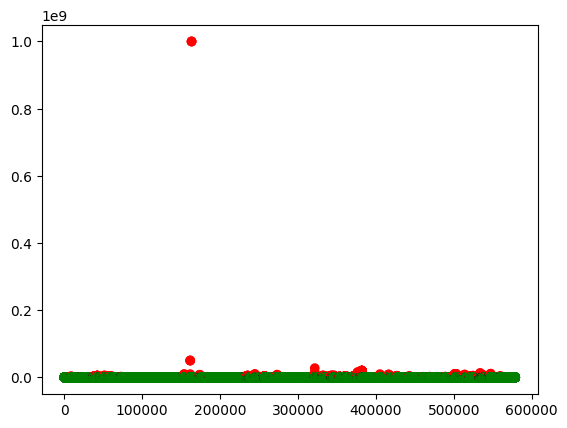

In [ ]:
IS = IsolationForest(contamination=0.01)
IS.fit(train_df[['median_list_price']])
train_df['outlier'] = IS.predict(train_df[['median_list_price']])

color = train_df['outlier'].map({1:'green', -1:'red'})
plt.scatter(train_df.index, train_df['median_list_price'], c=color)
plt.show()

In [ ]:
train_df['median_list_price'].describe()

,median_list_price
count,5.789500e+05
mean,3.729861e+05
std,2.314856e+06
min,0.000000e+00
25%,1.720000e+05
50%,2.750000e+05
75%,4.390000e+05
max,1.000000e+09


In [ ]:
train_df = train_df[train_df['median_list_price'] < 7000000]
test_df = test_df[test_df['median_list_price'] < 7000000]

In [ ]:
train_df.drop(columns=['outlier'], inplace=True)

# PRICE DISTRIBUTION AFTER REMOVING OUTLIERS

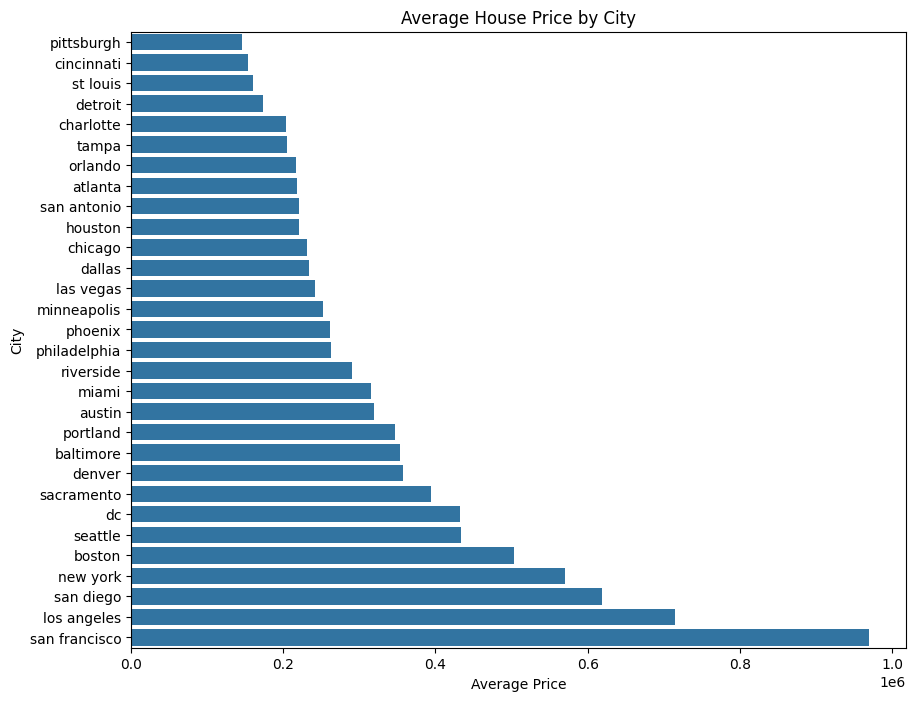

In [ ]:
avg_prices = train_df.groupby('city_full')['median_list_price'].mean().sort_values()
plt.figure(figsize=(10,8))
sns.barplot(y=avg_prices.index, x=avg_prices.values)
plt.xlabel("Average Price")
plt.ylabel("City")
plt.title("Average House Price by City")
plt.show()

# FREQUENCY ENCODER

In [ ]:
freq = train_df['zipcode'].value_counts()
train_df['zipcode_freq'] = train_df['zipcode'].map(freq)
test_df['zipcode_freq'] = test_df['zipcode'].map(freq).fillna(freq.min())

# TARGET ENCODER

In [ ]:
!pip install category_encoders
from category_encoders import TargetEncoder

In [ ]:
TE = TargetEncoder(cols=['city_full'], smoothing=10)
train_df['cityTE'] = TE.fit_transform(train_df['city_full'], train_df['price'])
test_df['cityTE'] = TE.transform(test_df['city_full'])

# DROP COLUMNS NOT NEEDED

In [ ]:
train_df.columns

Index(['median_sale_price', 'median_list_price', 'median_ppsf',
       'median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings',
       'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list',
       'off_market_in_two_weeks', 'city', 'zipcode', 'year', 'bank', 'bus',
       'hospital', 'mall', 'park', 'restaurant', 'school', 'station',
       'supermarket', 'Total_Population', 'Median_Age', 'Per_Capita_Income',
       'Total_Families_Below_Poverty', 'Total_Housing_Units', 'Median_Rent',
       'Median_Home_Value', 'Total_Labor_Force', 'Unemployed_Population',
       'Total_School_Age_Population', 'Total_School_Enrollment',
       'Median_Commute_Time', 'price', 'city_full', 'Latitude', 'Longitude',
       'month', 'quarter', 'zipcode_freq', 'cityTE'],
      dtype='object')

In [ ]:
columns_to_drop = ['zipcode','city_full','city']

train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

# MULTICOLINEARITY CHECK

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(df, target_col=None):
    """
    Calculate Variance Inflation Factor (VIF) for each numeric column in df.
    """
    # Keep only numeric columns
    numeric_df = df.select_dtypes(include=['float64', 'int64']).copy()

    # Drop target if provided
    if target_col and target_col in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=[target_col])

    # Add constant for statsmodels
    X = add_constant(numeric_df)

    # Compute VIF (skip the first column = constant)
    vif_data = pd.DataFrame()
    vif_data["feature"] = numeric_df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i + 1)  # skip constant at index 0
        for i in range(len(numeric_df.columns))
    ]

    return vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)


# Look at VIF and correlation with original training dataset
vif_table = calculate_vif(train_df, target_col="price")
print(vif_table)

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                         feature          VIF
0    Total_School_Age_Population          inf
1        Total_School_Enrollment          inf
2               Total_Population  6673.233124
3              Total_Labor_Force   837.684837
4            Median_Commute_Time   650.743820
5   Total_Families_Below_Poverty   576.882000
6            Total_Housing_Units    21.122267
7                   new_listings    20.346328
8                        quarter    17.419054
9                          month    17.378020
10                    homes_sold    14.131303
11         Unemployed_Population    12.883864
12                    restaurant    10.927119
13                          bank    10.675651
14                   supermarket     9.624556
15                 pending_sales     9.267202
16             Median_Home_Value     8.792314
17                     inventory     6.001580
18                        school     5.776475
19             median_list_price     5.772326
20             median_sale_price  

In [ ]:
high_vif = ['Total_School_Enrollment','Total_School_Age_Population','Total_Population','Total_Labor_Force','Median_Commute_Time','Total_Families_Below_Poverty','Total_Housing_Units','new_listings']

train_df.drop(columns=high_vif, inplace=True)
test_df.drop(columns=high_vif, inplace=True)

# SAVE DATASETS

In [ ]:
train_df.to_csv('/content/Drive/MyDrive/House_price_predictor/dataset/featured_data/featured_train_data.csv', index=False)
test_df.to_csv('/content/Drive/MyDrive/House_price_predictor/dataset/featured_data/featured_test_data.csv', index=False)